
#Introduction

The [dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) I choosed contain chest X-Ray images of healthy patients and patients with pneumonia but there're only 16 images for validation so I used [validation](https://www.kaggle.com/pcbreviglieri/pneumonia-xray-images?select=val) images from another dataset

![link](https://i.imgur.com/jZqpV51.png)

In [ ]:
import numpy as np
import tensorflow as tf
import keras
import os, shutil
import seaborn as sns

print ("TensorFlow version: " + tf.__version__)
print ("Keras version: " + keras.__version__)

from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd

import cv2

TensorFlow version: 2.5.0
Keras version: 2.5.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# The path to store trained models
models_dir = '/content/drive/MyDrive/ML_models/Pneumonia_Project/'
if not os.path.exists(models_dir):
    os.mkdir(models_dir)

# The path to the directory where the original dataset was uncompressed
original_dataset_dir = '/content/drive/MyDrive/pneumonia_dataset/'

# The directory where we will store our smaller dataset
base_dir = '/content/drive/MyDrive/pneumonia_dataset/chest_xray/'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

# Directories for our training, validation and test splits
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'val')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

# Directory with our training normal pictures
train_normal_dir = os.path.join(train_dir, 'NORMAL')
if not os.path.exists(train_normal_dir):
    os.mkdir(train_normal_dir)

# Directory with our training pneumonia pictures
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')
if not os.path.exists(train_pneumonia_dir):
    os.mkdir(train_pneumonia_dir)

# Directory with our validation normal pictures
validation_normal_dir = os.path.join(validation_dir, 'NORMAL')
if not os.path.exists(validation_normal_dir):
    os.mkdir(validation_normal_dir)

# Directory with our validation pneumonia pictures
validation_pneumonia_dir = os.path.join(validation_dir, 'PNEUMONIA')
if not os.path.exists(validation_pneumonia_dir):
    os.mkdir(validation_pneumonia_dir)

# Directory with our test normal pictures
test_normal_dir = os.path.join(test_dir, 'NORMAL')
if not os.path.exists(test_normal_dir):
    os.mkdir(test_normal_dir)

# Directory with our test pneumonia pictures
test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA')
if not os.path.exists(test_pneumonia_dir):
    os.mkdir(test_pneumonia_dir)


In [ ]:
print("Working Directory Contents:", os.listdir(base_dir))
print("length of cases in training set:",len(os.listdir(train_normal_dir)) + len(os.listdir(train_pneumonia_dir)))
print("length of pneumonia cases in training set:",len(os.listdir(train_pneumonia_dir)))
print("length of normal cases in training set:",len(os.listdir(train_normal_dir)))

Working Directory Contents: ['.DS_Store', 'val', 'test', 'train']
length of cases in training set: 5216
length of pneumonia cases in training set: 3875
length of normal cases in training set: 1341


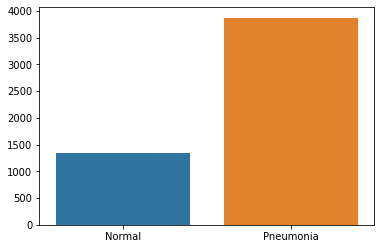

In [ ]:
sns.barplot(x=['Normal','Pneumonia'],y=[len(os.listdir(train_normal_dir)),len(os.listdir(train_pneumonia_dir))])

In [ ]:
print("length of cases in testing set:",len(os.listdir(test_normal_dir)) + len(os.listdir(test_pneumonia_dir)))
print("length of pneumonia cases in testing set:",len(os.listdir(test_pneumonia_dir)))
print("length of normal cases in testing set:",len(os.listdir(test_normal_dir)))

length of cases in testing set: 624
length of pneumonia cases in testing set: 390
length of normal cases in testing set: 234


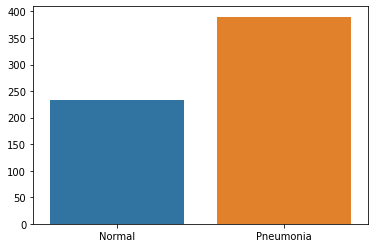

In [ ]:
sns.barplot(x=['Normal','Pneumonia'],y=[len(os.listdir(test_normal_dir)),len(os.listdir(test_pneumonia_dir))])

In [ ]:
print("length of cases in validation set:",len(os.listdir(validation_normal_dir)) + len(os.listdir(validation_pneumonia_dir)))
print("length of pneumonia cases in validation set:",len(os.listdir(validation_pneumonia_dir)))
print("length of normal cases in validation set:",len(os.listdir(validation_normal_dir)))

length of cases in validation set: 1028
length of pneumonia cases in validation set: 773
length of normal cases in validation set: 255


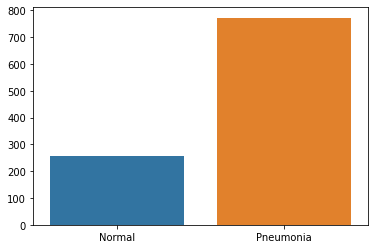

In [ ]:
sns.barplot(x=['Normal','Pneumonia'],y=[len(os.listdir(validation_normal_dir)),len(os.listdir(validation_pneumonia_dir))])

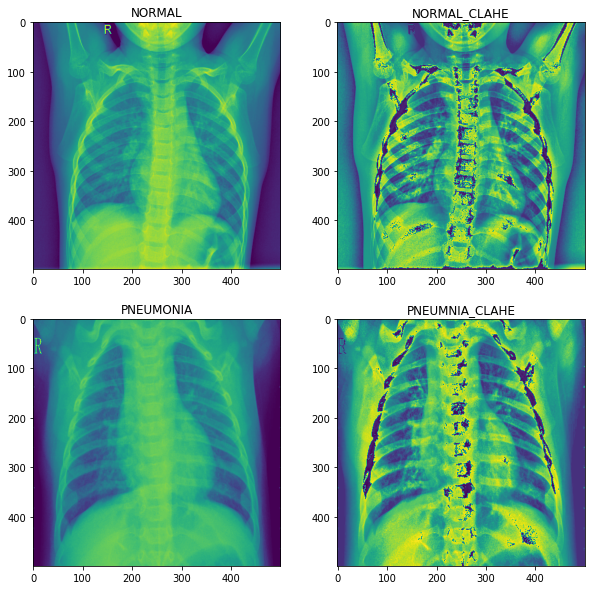

In [ ]:
# Quick look to the images 
clahe = cv2.createCLAHE(clipLimit = 5)


img_name = 'IM-0115-0001.jpeg'
img_normal = cv2.imread('/content/drive/MyDrive/pneumonia_dataset/chest_xray/train/NORMAL/' + img_name)
img_normal = cv2.resize(img_normal, (500,500))
img_normal = cv2.cvtColor(img_normal, cv2.COLOR_BGR2GRAY)
img_normal_clahe = clahe.apply(img_normal) + 30

img_name_1 = 'person1000_virus_1681.jpeg'
img_pneumonia = cv2.imread('/content/drive/MyDrive/pneumonia_dataset/chest_xray/train/PNEUMONIA/' + img_name_1)
img_pneumonia = cv2.resize(img_pneumonia, (500,500))
img_pneumonia = cv2.cvtColor(img_pneumonia, cv2.COLOR_BGR2GRAY)
img_pneumonia_clahe = clahe.apply(img_pneumonia) + 30

fig, axs = plt.subplots(2,2,figsize=(10,10))
axs[0,0].imshow(img_normal)
axs[0,0].set_title("NORMAL")
axs[0,1].imshow(img_normal_clahe)
axs[0,1].set_title("NORMAL_CLAHE")
axs[1,0].imshow(img_pneumonia)
axs[1,0].set_title("PNEUMONIA")
axs[1,1].imshow(img_pneumonia_clahe)
axs[1,1].set_title("PNEUMNIA_CLAHE");

In [ ]:
def PlotAccuracyComparison(acc, val_acc, lab = '*'):
    plt.clf()   # clear figure
    plt.rcParams['figure.figsize'] = (25.0, 5.0) # set default size of plots
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training accuracy for ' + lab)
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy for ' + lab)
    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def PlotLossComparison(loss, val_loss, lab = '*'):
    plt.clf()   # clear figure
    plt.rcParams['figure.figsize'] = (25.0, 5.0) # set default size of plots
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'bo', label='Training loss for ' + lab)
    plt.plot(epochs, val_loss, 'b', label='Validation loss for ' + lab)
    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

#Model1 (basic CNN)




In [ ]:
img_rows = 150
img_cols = 150

model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Flatten())
model1.add(layers.Dense(512, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [ ]:
model1.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    # This is the target directory
    train_dir,
    # All images will be resized to 150x150
    target_size=(img_rows, img_cols),
    # The size of baches of images
    batch_size=20,
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    # This is the target directory
    validation_dir,
    # All images will be resized to 150x150
    target_size=(img_rows, img_cols),
    # The size of baches of images
    batch_size=20,
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 1028 images belonging to 2 classes.


In [ ]:
history1 = model1.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
100/100 [==============================] - 1119s 11s/step - loss: 0.5461 - acc: 0.7462 - val_loss: 0.2999 - val_acc: 0.9170
Epoch 2/15
100/100 [==============================] - 572s 6s/step - loss: 0.2564 - acc: 0.9045 - val_loss: 0.1787 - val_acc: 0.9360
Epoch 3/15
100/100 [==============================] - 384s 4s/step - loss: 0.1776 - acc: 0.9247 - val_loss: 0.1469 - val_acc: 0.9450
Epoch 4/15
100/100 [==============================] - 251s 2s/step - loss: 0.1600 - acc: 0.9351 - val_loss: 0.1855 - val_acc: 0.9310
Epoch 5/15
100/100 [==============================] - 156s 2s/step - loss: 0.1383 - acc: 0.9418 - val_loss: 0.1131 - val_acc: 0.9600
Epoch 6/15
100/100 [==============================] - 102s 1s/step - loss: 0.1190 - acc: 0.9618 - val_loss: 0.1169 - val_acc: 0.9570
Epoch 7/15
100/100 [==============================] - 89s 900ms/step - loss: 0.0943 - acc: 0.9707 - val_loss: 0.1023 - val_acc: 0.9580
Epoch 8/15
100/100 [==============================] - 77s 762ms/s

In [ ]:
model1.save(models_dir + '/normal_vs_pneumonia-1.h5')

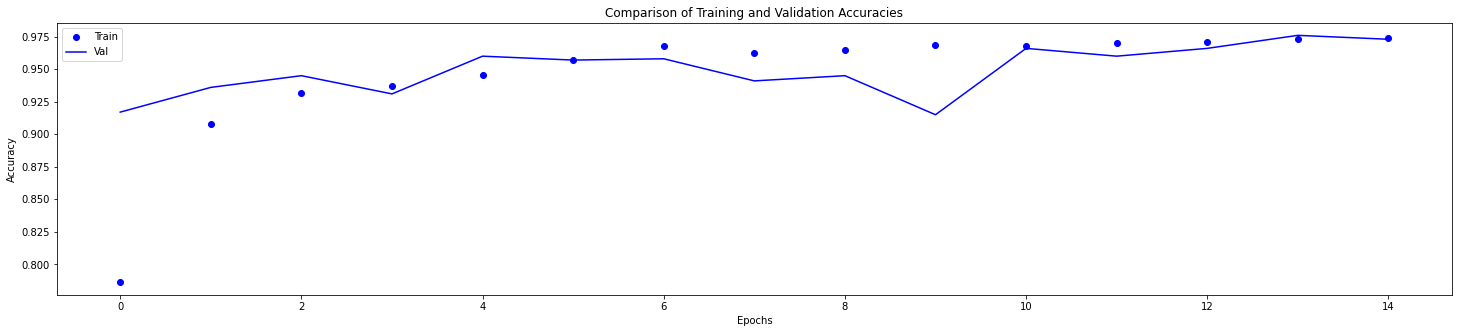

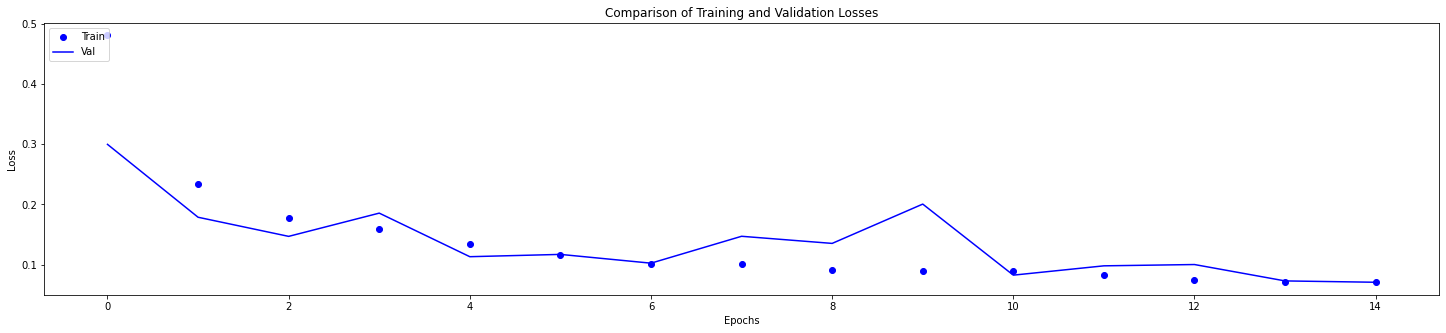

In [ ]:
acc1 = history1.history['acc']
val_acc1 = history1.history['val_acc']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

PlotAccuracyComparison(acc1, val_acc1, lab = 'Model 1')

PlotLossComparison(loss1, val_loss1, lab = 'Model 1')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

from PIL import Image
def predict(image_path, model):
    im = cv2.imread(image_path)
    test_image = np.asarray(im)
    processed_test_image = process_image(test_image)
    processed_test_image = np.expand_dims(processed_test_image, axis = 0)
    
    ps = model.predict(processed_test_image)
    return ps
    
def process_image(image):
    image = image/255
    image = cv2.resize(image, (150,150))
    return image

def testing(model, test_df):
    """ the passed data must be the img_path columns and label column"""
    base_pred =[]
    for image in test_df.img_path:
        base_pred.append(predict(image , model)[0][0])
    
    final_base_pred  = np.where(np.array(base_pred)>0.5,1,0)
    actual_label = test_df['label']
    # print(final_base_pred)

    print(classification_report(actual_label, final_base_pred))
    matrix=confusion_matrix(actual_label, final_base_pred)
    sns.heatmap(matrix,square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['NORMAL', 'PNEUMONIA'],
            yticklabels=['NORMAL', 'PNEUMONIA'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

In [ ]:
test_data = []

for filename in os.listdir(test_normal_dir):
    test_data.append((os.path.join(test_normal_dir,filename),0))
for filename in os.listdir(test_pneumonia_dir):
    test_data.append((os.path.join(test_pneumonia_dir,filename),1))    
        
    
test_df = pd.DataFrame(test_data, columns = ['img_path','label'], index = None)
# this test_df must contain the img_path and label column in order to run the function 

              precision    recall  f1-score   support

           0       0.97      0.36      0.52       234
           1       0.72      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.84      0.68      0.68       624
weighted avg       0.81      0.75      0.72       624



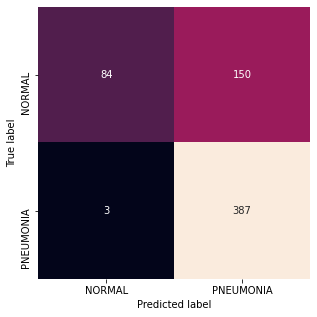

In [ ]:
first_model = keras.models.load_model('/content/drive/MyDrive/ML_models/Pneumonia_Project/normal_vs_pneumonia-1.h5')
testing(first_model, test_df)

In [ ]:
img_rows = 150
img_cols = 150

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      width_shift_range=0.05,
      height_shift_range=0.05,
      shear_range=0.15,
      zoom_range=0.15,
      horizontal_flip=True,
      fill_mode='nearest',
      brightness_range=[0.5,1.0])

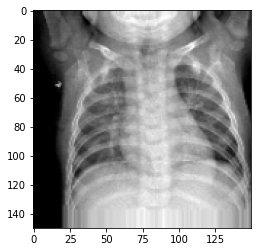

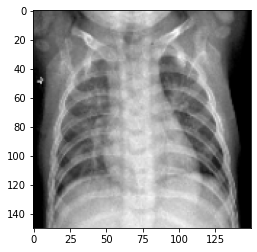

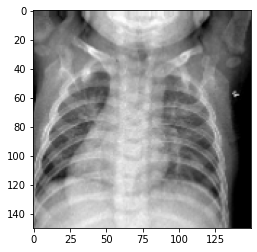

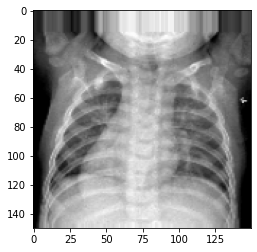

In [ ]:
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_normal_dir, fname) for fname in os.listdir(train_normal_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(img_rows, img_cols))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

#Model 2 (CNN with data augmentation)

In [ ]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5,1.0],
    horizontal_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(img_rows, img_cols),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_rows, img_cols),
        batch_size=32,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_rows, img_cols),
        batch_size=32,
        class_mode='binary')


Found 5216 images belonging to 2 classes.
Found 1028 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
history2 = model2.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples//train_generator.batch_size,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples//validation_generator.batch_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
163/163 [==============================] - 117s 701ms/step - loss: 0.5617 - acc: 0.7440 - val_loss: 0.4224 - val_acc: 0.7676
Epoch 2/15
163/163 [==============================] - 114s 698ms/step - loss: 0.4000 - acc: 0.8221 - val_loss: 0.7250 - val_acc: 0.6504
Epoch 3/15
163/163 [==============================] - 113s 694ms/step - loss: 0.3412 - acc: 0.8489 - val_loss: 0.2732 - val_acc: 0.8818
Epoch 4/15
163/163 [==============================] - 113s 696ms/step - loss: 0.2754 - acc: 0.8844 - val_loss: 0.3070 - val_acc: 0.8604
Epoch 5/15
163/163 [==============================] - 114s 699ms/step - loss: 0.2747 - acc: 0.8814 - val_loss: 0.1764 - val_acc: 0.9336
Epoch 6/15
163/163 [==============================] - 113s 693ms/step - loss: 0.2358 - acc: 0.9074 - val_loss: 0.1758 - val_acc: 0.9395
Epoch 7/15
163/163 [==============================] - 113s 696ms/step - loss: 0.2225 - acc: 0.9123 - val_loss: 0.1910 - val_acc: 0.9238
Epoch 8/15
163/163 [============================

In [ ]:
model2.save(models_dir + '/normal_vs_pneumonia-2.h5')

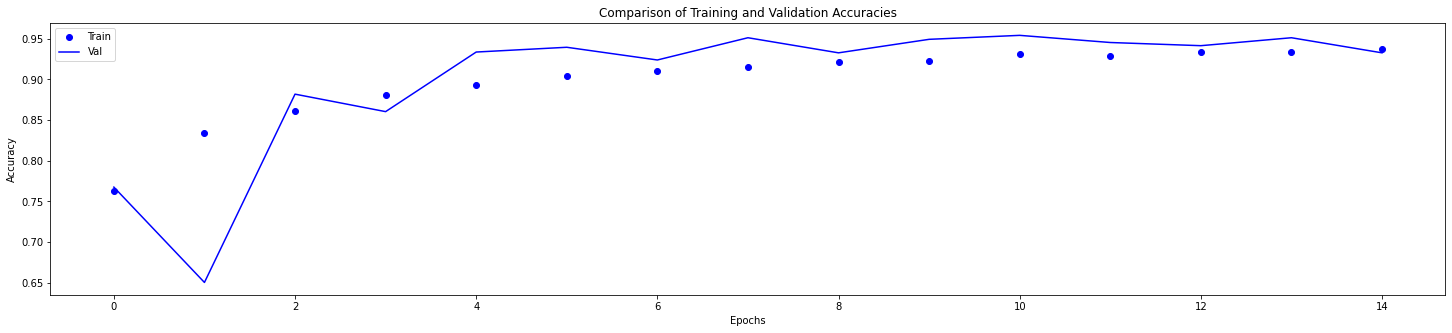

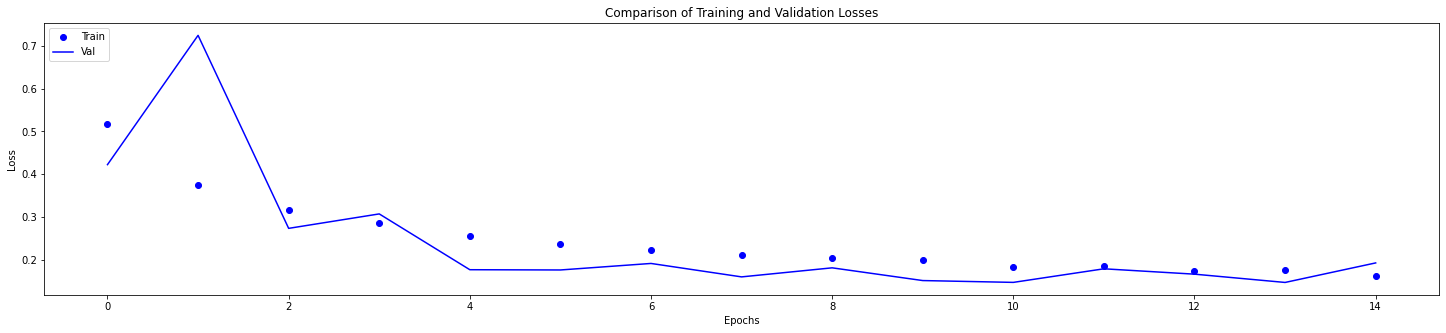

In [ ]:
acc2 = history2.history['acc']
val_acc2 = history2.history['val_acc']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

PlotAccuracyComparison(acc2, val_acc2, lab = 'Model 2')

PlotLossComparison(loss2, val_loss2, lab = 'Model 2')

In [ ]:
test_data = []

for filename in os.listdir(test_normal_dir):
    test_data.append((os.path.join(test_normal_dir,filename),0))
for filename in os.listdir(test_pneumonia_dir):
    test_data.append((os.path.join(test_pneumonia_dir,filename),1))    
        
    
test_df = pd.DataFrame(test_data, columns = ['img_path','label'], index = None)
# this test_df must contain the img_path and label column in order to run the function 

              precision    recall  f1-score   support

           0       0.89      0.86      0.87       234
           1       0.92      0.93      0.93       390

    accuracy                           0.91       624
   macro avg       0.90      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624



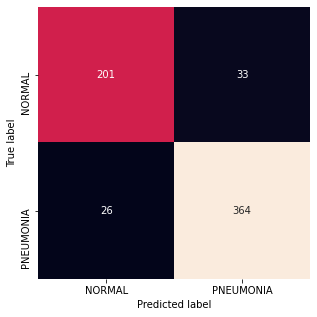

In [ ]:
second_model = keras.models.load_model('/content/drive/MyDrive/ML_models/Pneumonia_Project/normal_vs_pneumonia-2.h5')
testing(second_model, test_df)

# Model 3 (CNN with data augmentation and less complicated model)

In [ ]:
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Dropout(0.1))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Dropout(0.1))
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Flatten())
model3.add(layers.Dropout(0.3))
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)      

In [ ]:
history3 = model3.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples//train_generator.batch_size,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples//validation_generator.batch_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
163/163 [==============================] - 1779s 11s/step - loss: 0.5512 - acc: 0.7336 - val_loss: 0.4578 - val_acc: 0.7549
Epoch 2/15
163/163 [==============================] - 86s 530ms/step - loss: 0.4521 - acc: 0.7827 - val_loss: 0.3122 - val_acc: 0.8486
Epoch 3/15
163/163 [==============================] - 86s 526ms/step - loss: 0.3526 - acc: 0.8424 - val_loss: 0.2485 - val_acc: 0.9111
Epoch 4/15
163/163 [==============================] - 86s 525ms/step - loss: 0.3126 - acc: 0.8641 - val_loss: 0.2188 - val_acc: 0.9180
Epoch 5/15
163/163 [==============================] - 85s 524ms/step - loss: 0.2940 - acc: 0.8748 - val_loss: 0.1962 - val_acc: 0.9307
Epoch 6/15
163/163 [==============================] - 86s 527ms/step - loss: 0.2605 - acc: 0.8842 - val_loss: 0.1947 - val_acc: 0.9326
Epoch 7/15
163/163 [==============================] - 86s 527ms/step - loss: 0.2461 - acc: 0.9044 - val_loss: 0.1845 - val_acc: 0.9404
Epoch 8/15
163/163 [==============================] - 8

In [ ]:
model3.save(models_dir + '/normal_vs_pneumonia-3-1.h5')

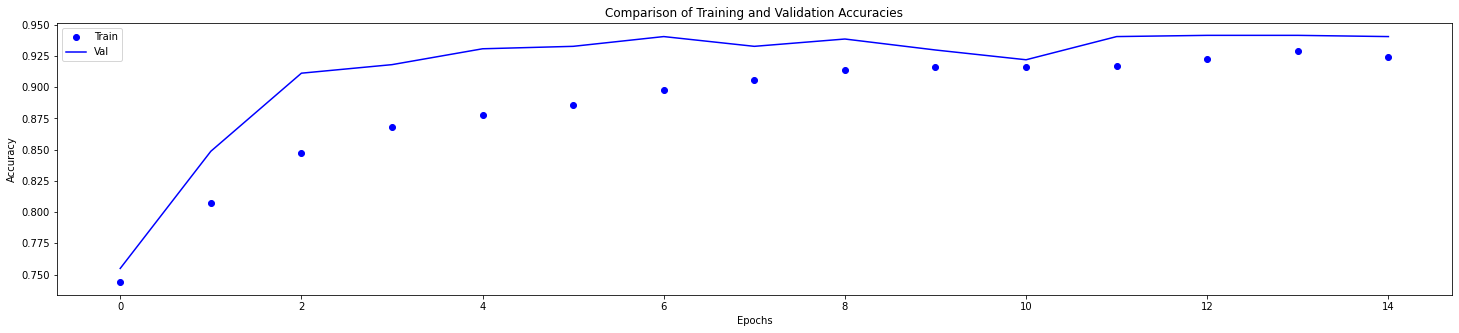

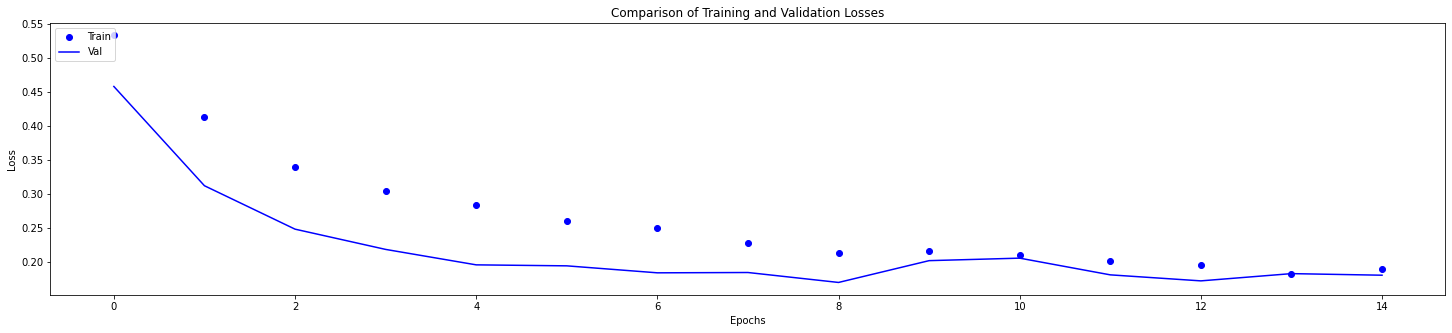

In [ ]:
acc3 = history3.history['acc']
val_acc3 = history3.history['val_acc']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

PlotAccuracyComparison(acc3, val_acc3, lab = 'Model 3')

PlotLossComparison(loss3, val_loss3, lab = 'Model 3')

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       234
           1       0.90      0.94      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.89      0.89       624
weighted avg       0.90      0.90      0.90       624



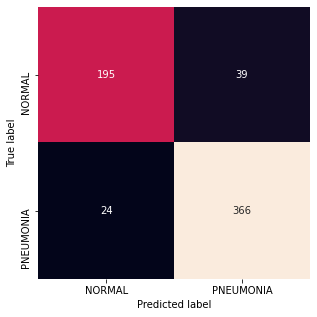

In [ ]:
third_model = keras.models.load_model('/content/drive/MyDrive/ML_models/Pneumonia_Project/normal_vs_pneumonia-3-1.h5')
testing(third_model, test_df)

#Model 4 (VGG19 network)

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19

In [ ]:
conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
batch_size = 10
def extract_features(directory, batch_size, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        # put the input data through the conv_base and store the outputs in features
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a for-loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, batch_size, 1300)
validation_features, validation_labels = extract_features(validation_dir, batch_size, 250)
test_features, test_labels = extract_features(test_dir, batch_size, 200)

Found 5216 images belonging to 2 classes.
Found 1028 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
train_features = np.reshape(train_features, (1300, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (250, 4 * 4 * 512))
test_features = np.reshape(test_features, (200, 4 * 4 * 512))
print (train_features.shape)
print (validation_features.shape)
print (test_features.shape)
flatten_layer_size = train_features.shape[1]  # 4 * 4 * 512

(1300, 8192)
(250, 8192)
(200, 8192)


In [ ]:
model4 = models.Sequential()
model4.add(layers.Dense(256, activation='relu', input_dim=flatten_layer_size))
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(1, activation='sigmoid'))

model4.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history4 = model4.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(validation_features, validation_labels))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
41/41 [==============================] - 1s 14ms/step - loss: 3.1220 - acc: 0.6930 - val_loss: 0.5108 - val_acc: 0.9000
Epoch 2/30
41/41 [==============================] - 0s 7ms/step - loss: 1.5228 - acc: 0.8517 - val_loss: 0.3576 - val_acc: 0.9280
Epoch 3/30
41/41 [==============================] - 0s 6ms/step - loss: 0.9720 - acc: 0.8871 - val_loss: 0.2798 - val_acc: 0.9360
Epoch 4/30
41/41 [==============================] - 0s 7ms/step - loss: 0.6058 - acc: 0.8988 - val_loss: 0.3104 - val_acc: 0.9320
Epoch 5/30
41/41 [==============================] - 0s 7ms/step - loss: 0.6162 - acc: 0.9177 - val_loss: 0.2545 - val_acc: 0.9400
Epoch 6/30
41/41 [==============================] - 0s 7ms/step - loss: 0.5208 - acc: 0.9152 - val_loss: 0.3012 - val_acc: 0.9400
Epoch 7/30
41/41 [==============================] - 0s 7ms/step - loss: 0.4585 - acc: 0.9266 - val_loss: 0.2255 - val_acc: 0.9480
Epoch 8/30
41/41 [==============================] - 0s 7ms/step - loss: 0.4102 - acc: 0.9

In [ ]:
model4.save(models_dir + '/normal_vs_pneumonia-3.h5')

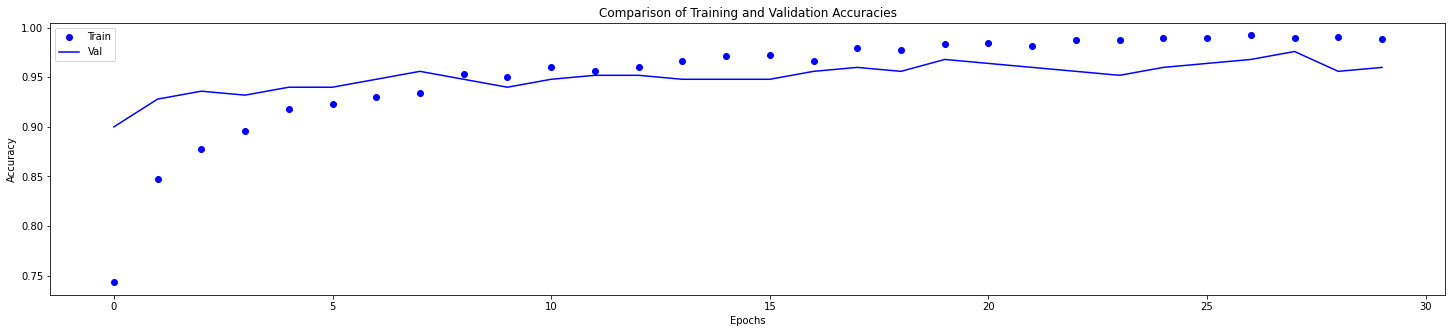

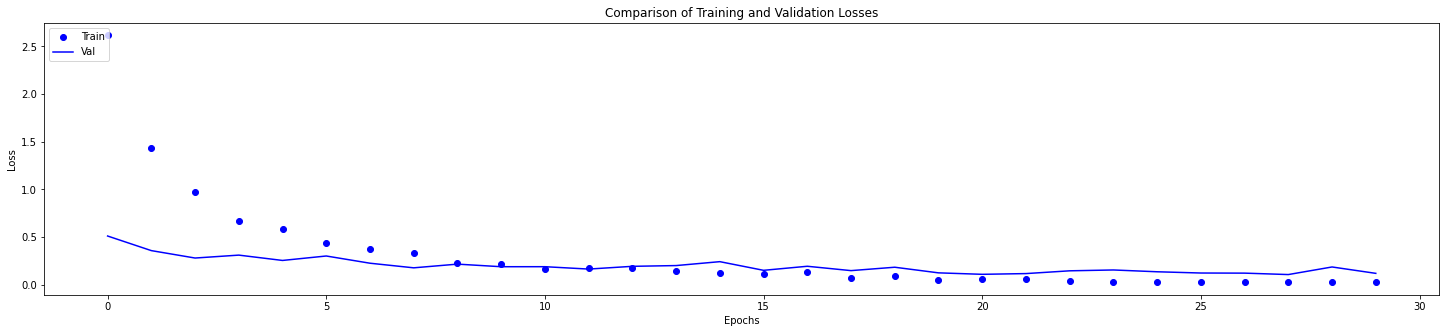

In [ ]:
acc4 = history4.history['acc']
val_acc4 = history4.history['val_acc']
loss4 = history4.history['loss']
val_loss4 = history4.history['val_loss']

PlotAccuracyComparison(acc4, val_acc4, lab = 'Model 4')

PlotLossComparison(loss4, val_loss4, lab = 'Model 4')

#Conclusion:
<li> Dataset contained very small amount of validation images so I decided to use another dataset for validation
<li> 1st model returned good results in accuracies and losses but confusion matrix shows that images were classified wrongly. It might be caused by inbalanced data
<li> 2nd model gave me similar results in accuracies and losses but much better results in classification which is showed on the confusion matix. Data augmentation helped in this case
<li> 3rd model resulted in pretty much same results as 2nd model but it was better optimised (50% less parameters than 2nd model). Model was learing quicker than the 2nd one due to less amount of parameters.
<li> In 4th model I used transfer learing using VGG19 network which also resulted in good accuracies and losses